In [1]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings


from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.


In [2]:
np.random.seed(8)

In [3]:
!pwd

/home/kumarbio/rai00016/Capstone/Code


In [4]:
class_names = os.listdir('/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Train/')
target_dirs = {target: '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/' + target for target in ['Train', 'Validation', 'Test']}

In [5]:
print(class_names)
print(target_dirs)

['airplane', 'baseball_diamond', 'beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'golf_course', 'harbor', 'intersection', 'medium_residential', 'mobile_home_park', 'overpass', 'parking_lot', 'river', 'runway', 'sparse_residential', 'storage_tank', 'tennis_court']
{'Train': '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Train', 'Validation': '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Validation', 'Test': '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Test'}


In [6]:
def get_bottleneck_features(model, dataset, batch_size=64):
    print("Generating dataset")
    image_data_gen = ImageDataGenerator(rescale=1/255.0)
    image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                        batch_size=batch_size,
                                                        shuffle=False)
    image_count = 0
    X_batches, Y_batches = [], []
    for X, Y in image_generator:
        X_batches.append(model.predict_on_batch(X))
        Y_batches.append(Y)
        image_count += X.shape[0]
    # Must interrupt image_generator
        if image_count >= image_generator.n:
            break
    X = np.concatenate(X_batches)
    Y = np.concatenate(Y_batches)
    return X, Y

In [7]:
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet')

In [8]:
num_classes = len(class_names)
X, Y = dict(), dict()
for dataset in [ 'Validation', 'Test', 'Train']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(pretrained_model, dataset)

Generating dataset
Found 1330 images belonging to 19 classes.
Generating dataset
Found 1330 images belonging to 19 classes.
Generating dataset
Found 10640 images belonging to 19 classes.


In [9]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [10]:
model = build_fully_connected(input_shape=X['Train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['Train'], Y['Train'], batch_size=64, epochs=300,
                              verbose=2, validation_data=(X['Validation'], Y['Validation']))

Train on 10640 samples, validate on 1330 samples
Epoch 1/300
 - 15s - loss: 1.9448 - accuracy: 0.4333 - val_loss: 0.8972 - val_accuracy: 0.7759
Epoch 2/300
 - 14s - loss: 1.1329 - accuracy: 0.6345 - val_loss: 0.7346 - val_accuracy: 0.8015
Epoch 3/300
 - 14s - loss: 0.9230 - accuracy: 0.6968 - val_loss: 0.5648 - val_accuracy: 0.8323
Epoch 4/300
 - 14s - loss: 0.7373 - accuracy: 0.7565 - val_loss: 0.5195 - val_accuracy: 0.8391
Epoch 5/300
 - 14s - loss: 0.6294 - accuracy: 0.7882 - val_loss: 0.4858 - val_accuracy: 0.8511
Epoch 6/300
 - 14s - loss: 0.5543 - accuracy: 0.8090 - val_loss: 0.4670 - val_accuracy: 0.8376
Epoch 7/300
 - 14s - loss: 0.4990 - accuracy: 0.8302 - val_loss: 0.4810 - val_accuracy: 0.8481
Epoch 8/300
 - 14s - loss: 0.4320 - accuracy: 0.8475 - val_loss: 0.4874 - val_accuracy: 0.8511
Epoch 9/300
 - 14s - loss: 0.4024 - accuracy: 0.8578 - val_loss: 0.4817 - val_accuracy: 0.8579
Epoch 10/300
 - 14s - loss: 0.3922 - accuracy: 0.8606 - val_loss: 0.4649 - val_accuracy: 0.8602


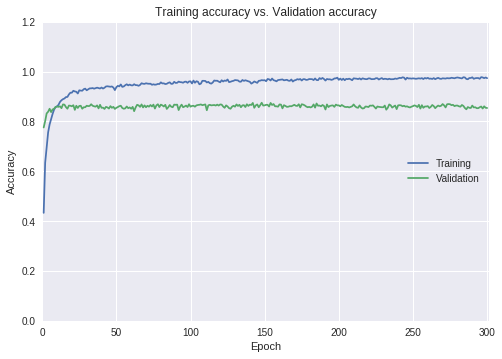

In [11]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

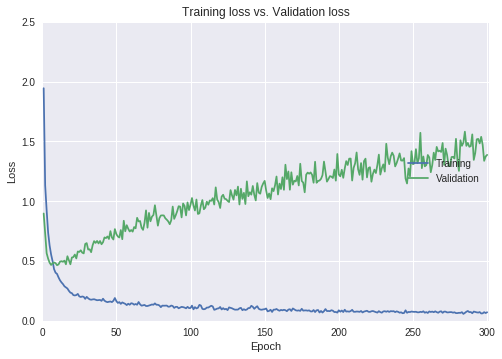

In [12]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [13]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(epochs)
# Merge training and validation data
X_train = np.concatenate([X['Train'], X['Validation']])
Y_train = np.concatenate([Y['Train'], Y['Validation']])

# Randomly shuffle X and Y
shuffle_index = np.random.permutation(len(X_train))
X_train = X_train[shuffle_index]
Y_train = Y_train[shuffle_index]
model = build_fully_connected(input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X_train, Y_train, batch_size=64, epochs=epochs, verbose=0)

10


In [14]:
y_pred = model.predict_classes(X['Test'], verbose=0)

In [15]:
y_test = np.nonzero(Y['Test'])[1]
accuracy = accuracy_score(y_test, y_pred)

In [16]:
print(accuracy)
print(classification_report(y_test, y_pred))

0.8225563909774436
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        70
           1       0.82      0.73      0.77        70
           2       0.88      0.94      0.91        70
           3       0.99      0.96      0.97        70
           4       0.72      0.77      0.74        70
           5       0.90      0.91      0.91        70
           6       0.81      0.79      0.80        70
           7       0.94      0.86      0.90        70
           8       0.85      0.94      0.89        70
           9       0.87      0.76      0.81        70
          10       0.54      0.71      0.62        70
          11       0.75      0.69      0.72        70
          12       0.90      0.87      0.88        70
          13       0.89      0.89      0.89        70
          14       0.93      0.89      0.91        70
          15       0.86      0.70      0.77        70
          16       0.86      0.84      0.85        70
        